In [1]:
import xarray as xr
import matplotlib.pylab as plt
import Rbeast as rb
import numpy as np
import cartopy.crs as ccrss
import cartopy.feature as cf
import matplotlib as mpl
import pandas as pd
import my_funs
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import BallTree, DistanceMetric
from causalimpact import CausalImpact
import pickle
from sklearn.impute import IterativeImputer
from dask.diagnostics import ProgressBar
from my_funs import est_trend
mpl.rcParams["mathtext.default"] = "regular"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = dir + "/codes/outputs/"
Fig_dir = dir + "/codes/manuscript/figures/"

def outliers_index(data, m=3.5):
    """
    Returns true if a value is outlier

    :param int data: numpy array
    :param int m: # of std to include data 
    """
    import numpy as np
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d / mdev if mdev else 0.
    return ~(s < m)

Initialization done!


/data/home/hamiddashti/hamid/nasa_above/greeness/codes/src/my_funs.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
2023-07-14 08:13:51.622930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follo

In [2]:
nirv = xr.open_dataarray("../../data/processed_data/landsat/resampled/nirv.nc")

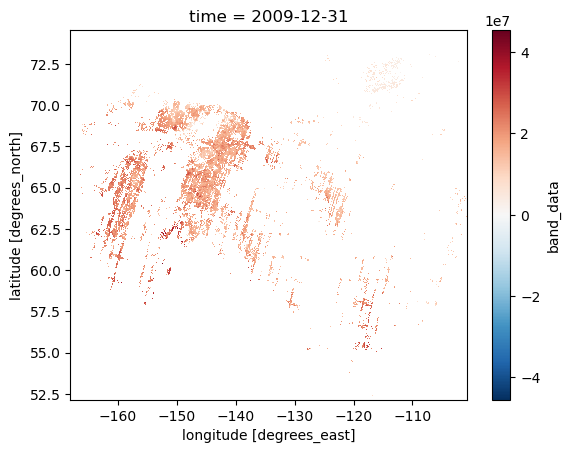

In [15]:
nirv.isel(time=25).plot()

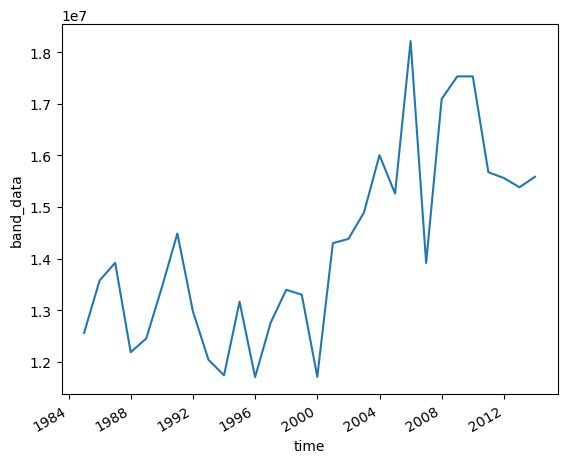

In [9]:
nirv.mean(["lat","lon"])

On the first run, check the CPU instruction set ... 

15
CPU Vendor:
    AMD         = No
    Intel       = Yes
 
OS Features:
    OS AVX      = Yes
    OS AVX512   = No

Hardware Features:
    MMX         = Yes
    x64         = Yes
    ABM         = Yes
    RDRAND      = Yes
    RDSEED      = No
    BMI1        = Yes
    BMI2        = Yes
    ADX         = No
    MPX         = No
    PREFETCHW   = No
    PREFETCHWT1 = No
    RDPID       = No
    GFNI        = No
    VAES        = No

SIMD: 128-bit
    SSE         = Yes
    SSE2        = Yes
    SSE3        = Yes
    SSSE3       = Yes
    SSE4a       = No
    SSE4.1      = Yes
    SSE4.2      = Yes
    AES-NI      = Yes
    SHA         = No

SIMD: 256-bit
    AVX         = Yes
    XOP         = No
    FMA3        = Yes
    FMA4        = No
    AVX2        = Yes

SIMD: 512-bit
    AVX512-F         = No
    AVX512-CD        = No
    AVX512-PF        = No
    AVX512-ER        = No
    AVX512-VL        = No
    AVX512-BW        = No
    A

(<Figure size 640x480 with 5 Axes>,
 array([<AxesSubplot:xlabel='[]', ylabel='trend'>,
        <AxesSubplot:xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot:xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot:xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot:xlabel='time', ylabel='error'>], dtype=object))

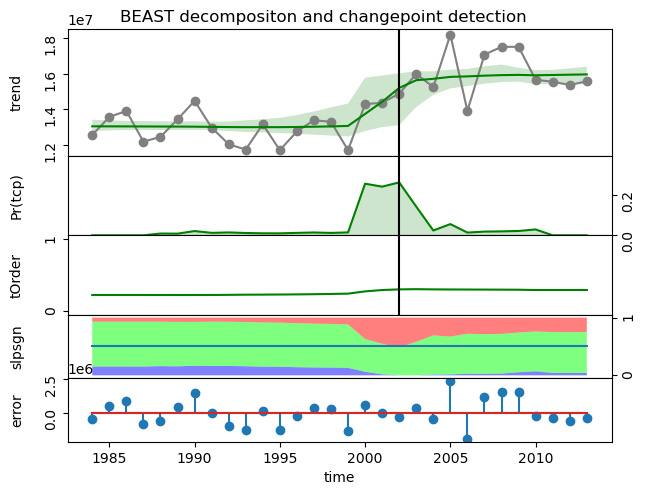

In [10]:
nirv_rbeast = rb.beast(nirv.mean(["lat","lon"]).values,
                       season="none",
                       start=1984,
                       tseg_minlength=3)
rb.plot(nirv_rbeast)

In [100]:
percent = xr.open_dataset(
    "../data/percent_cover.nc")["__xarray_dataarray_variable__"]
percent = percent.sel(time=slice(
    1984, 2013))*100  # select to 2013 consistent with LAI and NDVI
# Maximum annual LAI
lai = xr.open_dataarray("../data/lai_annual_resample_max.nc").rename({
    "latitude":
    "lat",
    "longitude":
    "lon"
})

percent["lat"] = lai["lat"]
percent["lon"] = lai["lon"]
t = pd.date_range(start="1984", end="2014", freq="A-Dec").year
arr = xr.open_dataarray("../data/arr_id.nc")
# Just a simple xarray structure to replace data with other arrays calculated later (for the ease of plotting)
repo = lai.isel(time=0)
swi = xr.open_dataarray("/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/swi/swi.nc")

# trend_total = xr.open_dataset("/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/noaa_nc/lai_fapar/trend/lai_max_trend.nc")
# trend_nv_lcc = xr.open_dataarray("/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/noaa_nc/lai_fapar/trend/lai_max_trend_nv_lcc.nc")
# trend_nv = xr.open_dataarray("/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/noaa_nc/lai_fapar/trend/lai_max_trend_nv.nc")
# trend_lcc = xr.open_dataarray("/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/noaa_nc/lai_fapar/trend/lai_max_trend_lcc.nc")

# we can do same analyses for NDVI (ignore now)
# Maximumn annual NDVI resampled to ef pixel size by taking the avrage
# ndvi = (
#     xr.open_dataarray(dir + "data/processed_data/landsat/resampled/ndvi_annual_max.nc")
#     / 1e4
# ).rename({"latitude": "lat", "longitude": "lon"})
# Select lai pixels where we have landsat NDVI as well
# lai_common = lai.where(np.isfinite(ndvi))
# ndvi_common = ndvi.where(np.isfinite(lai_common))
# ct = xr.open_dataset(
#     dir + "data/processed_data/confusion_tables/ct_all_years_corrected.nc"
# )


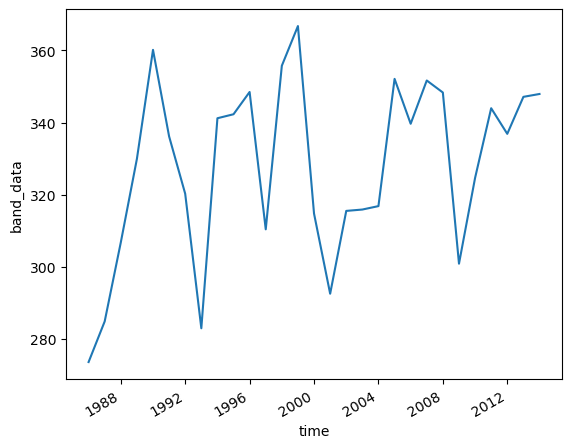

In [103]:
swi.mean(["lat","lon"]).plot()


#      OPTIONS used in the MCMC inference          #
#--------------------------------------------------#
#  Set extra.printOptions=0 to suppress printing   #
#--------------------------------------------------#

#......Start of displaying 'MetaData' ......
  metadata =  rb.args() ### or 'lambda: None': just get an empty object###
  metadata.isRegularOrdered = True
  metadata.season           = 'none'
  metadata.startTime        = 1984.00000
  metadata.deltaTime        = 1.00000
  metadata.whichDimIsTime   = 1
  metadata.missingValue     = float('nan')
  metadata.maxMissingRate   = 0.7500
  metadata.detrend          = False
#........End of displaying MetaData ........

#......Start of displaying 'prior' ......
  prior =  rb.args() ### or 'lambda: None': just get an empty object###
  prior.modelPriorType	  = 1
  prior.trendMinOrder	  = 0
  prior.trendMaxOrder	  = 1
  prior.trendMinKnotNum  = 0
  prior.trendMaxKnotNum  = 6
  prior.trendMinSepDist  = 3
  prior.K_MAX            = 14
  pri

(<Figure size 640x480 with 5 Axes>,
 array([<AxesSubplot:xlabel='[]', ylabel='trend'>,
        <AxesSubplot:xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot:xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot:xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot:xlabel='time', ylabel='error'>], dtype=object))

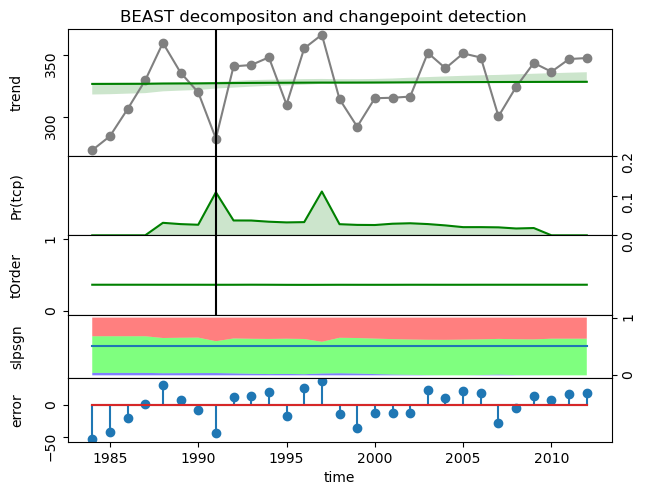

In [105]:
swi_rbeast = rb.beast(swi.mean(["lat","lon"]).values,
                       season="none",
                       start=1984,
                       tseg_minlength=3)
rb.plot(swi_rbeast)

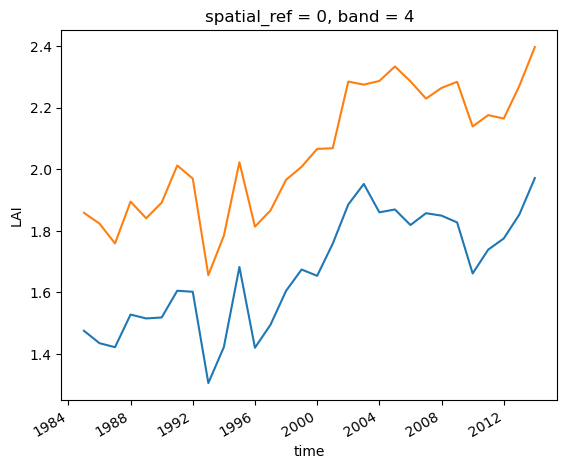

In [161]:
ef = percent.isel(band=0,time=20)
sh= percent.isel(band=8,time=20)
hb = percent.isel(band=3,time=20)
lai_ef = lai.where(ef>0.95)
lai.where(sh>0.95).mean(["lat","lon"]).plot()
lai.where(hb>0.95).mean(["lat","lon"]).plot()

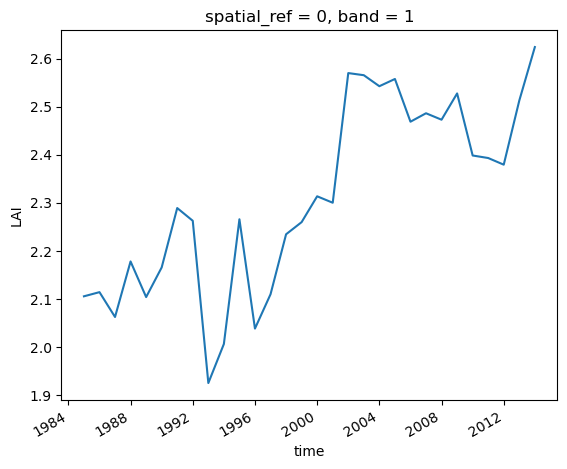

In [138]:
lai_ef.where(changed_pixels==False).mean(["lat","lon"]).plot()

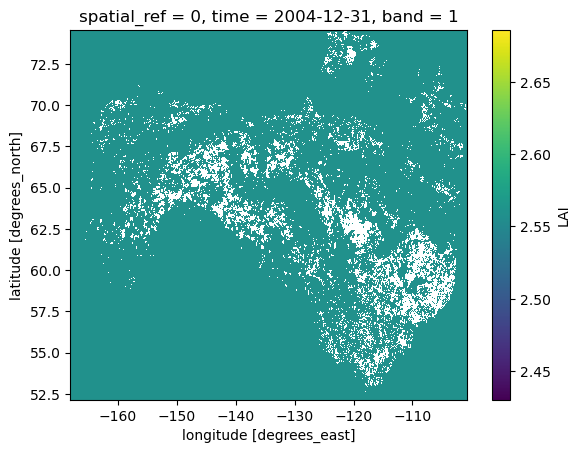

In [142]:
lai_ef.where(changed_pixels==False).isel(time=20).plot()
# lai_ef.where(changed_pixels==False).mean(["lat","lon"]).plot()

In [16]:
I_lai = outliers_index(lai,3.5)
lai_clean = lai.where(I_lai==False)

In [22]:
est_trend_lai = est_trend(lai_clean, "theilsen")

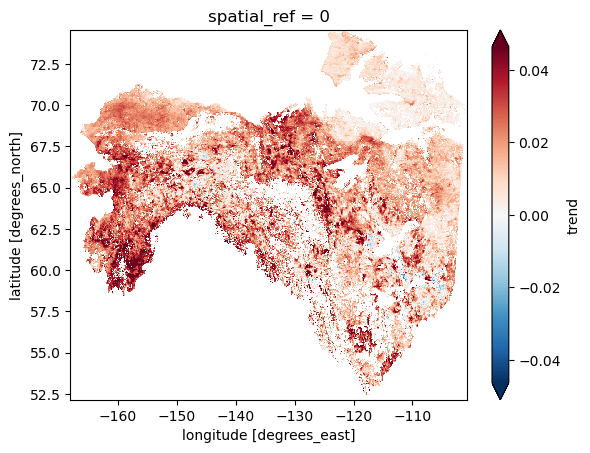

In [127]:
est_trend_lai["trend"].plot(robust=True)

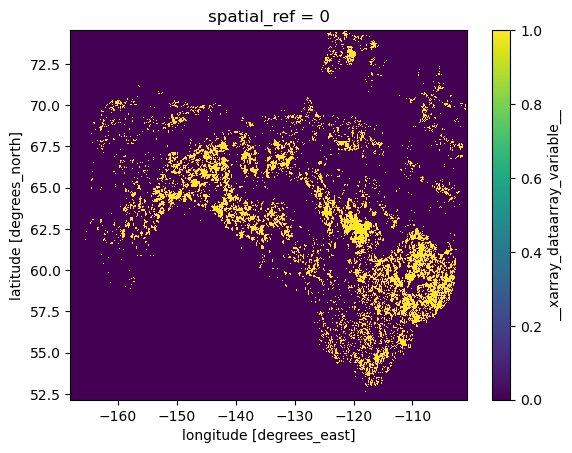

In [151]:
lc_diff = percent.diff("time")
diff = (abs(lc_diff) < 0.05) * 1
changed_pixels = (diff == 1).any(dim=["time", "band"])

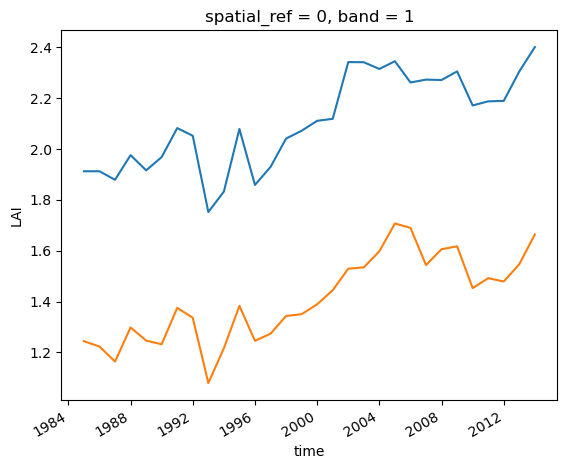

In [163]:
a = diff.isel(band=0)
c = (a==1).all(dim="time")
lai.where(c==False).mean(["lat","lon"]).plot()
lai.where(c==True).mean(["lat","lon"]).plot()

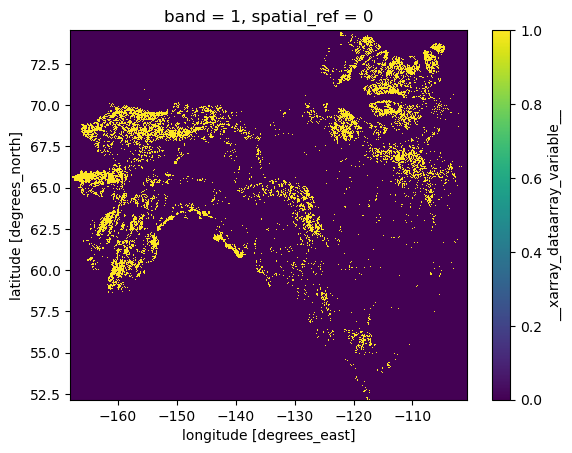

In [159]:
c.plot()

In [42]:
lai_changed = lai_clean.where(changed_pixels==True)
lai_not_changed = lai_clean.where(changed_pixels==False)

In [35]:
lai_changed_trend = est_trend(lai_changed,"theilsen")

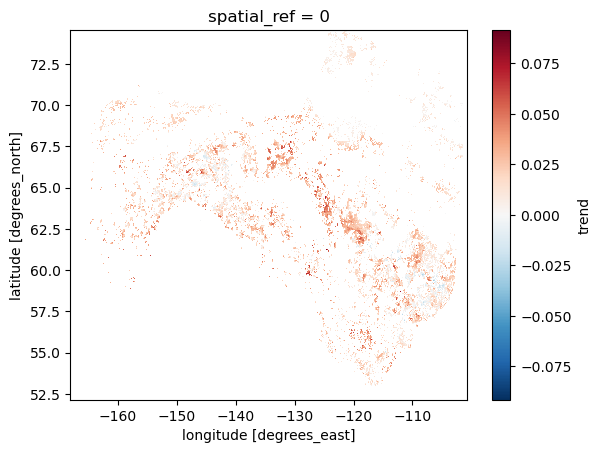

In [131]:
lai_changed_trend["trend"].plot()

In [119]:
swi_trend = est_trend(swi,"theilsen")

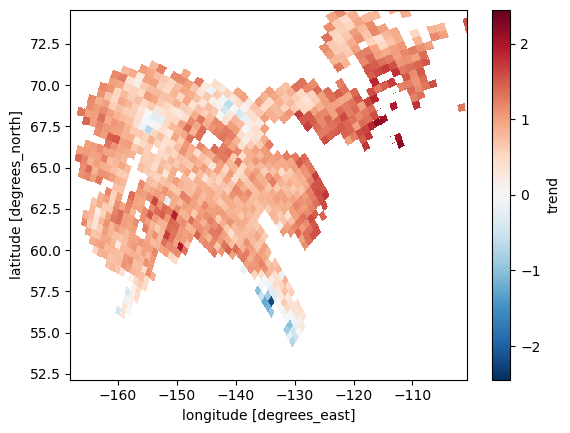

In [124]:
swi_trend["trend"].where(swi_trend["h"]<0.05).plot()

In [46]:
print(lai_changed_trend["trend"].mean().values)
print(trend_nv_lcc.mean().values)

0.01818932858218443
0.02341417482681452


In [ ]:
lai_changed_trend = est_trend(lai_changed,"theilsen")

In [47]:
lai_not_changed_trend = est_trend(lai_not_changed,"theilsen")

In [48]:
lai_not_changed_trend["trend"].mean()

<xarray.DataArray 'trend' ()>
array(0.01781105)
Coordinates:
    spatial_ref  int64 0

In [49]:
lai_changed_trend["trend"].mean()

<xarray.DataArray 'trend' ()>
array(0.01818933)
Coordinates:
    spatial_ref  int64 0

In [54]:
changed_pixels.to_netcdf("../../working/changed_pixels.nc")
lai_changed.isel(time=20).to_netcdf("../../working/lai_changed.nc")
lai_not_changed.isel(time=20).to_netcdf("../../working/lai_not_changed.nc")
lai_not_changed_trend["trend"].to_netcdf("../../working/trend_not_changed.nc")
lai_changed_trend["trend"].to_netcdf("../../working/trend_changed.nc")


In [76]:
winsize=7
changed_pixels_roll = (changed_pixels.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)
percent_cover_roll = (percent.rolling(
    {
        "lat": winsize,
        "lon": winsize
    }, center=True).construct({
        "lat": "lat_dim",
        "lon": "lon_dim"
    }).values)
trend_roll = (trend_total.rolling({
    "lat": winsize,
    "lon": winsize
},center=True).construct({
    "lat": "lat_dim",
                          "lon": "lon_dim"}).values)


<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (lat: 448, lon: 1348, lat_dim: 7, lon_dim: 7)
Coordinates:
  * lat          (lat) float32 74.53 74.47 74.43 74.38 ... 52.27 52.22 52.17
  * lon          (lon) float32 -168.1 -168.0 -168.0 ... -100.8 -100.8 -100.7
    spatial_ref  int64 0
Dimensions without coordinates: lat_dim, lon_dim
Data variables:
    trend        (lat, lon, lat_dim, lon_dim) float64 nan nan nan ... nan nan
    p_value      (lat, lon, lat_dim, lon_dim) float64 nan nan nan ... nan nan
    h            (lat, lon, lat_dim, lon_dim) float64 nan nan nan ... nan nan
Attributes:
    trend:    The estimated trend using Theilsen method
    p:        Estimated p_value using Mann-Kendall
    h:        1 if trend is significant (p<0.05), 0 otherwise>

In [66]:
I = np.argwhere(arr.values==215164)[0]
print(I)


[124 480]


### Apply Rbeast on landcover classes


In [ ]:
# Only EF, shrub and DF. Changes in other classes are not that substantial
ef_region_mean = percent.isel(band=0).mean(["lat", "lon"])  # Evergreen forest
sh_region_mean = percent.isel(band=2).mean(["lat", "lon"])  # shrub
hb_region_mean = percent.isel(band=3).mean(["lat", "lon"])  # herb
ef_region_mean_rbeast = rb.beast(ef_region_mean.values,
                       season="none",
                       start=1984,
                       tseg_minlength=3)
sh_region_mean_rbeast = rb.beast(sh_region_mean.values,
                       season="none",
                       start=1984,
                       tseg_minlength=3)
hb_region_mean_rbeast = rb.beast(hb_region_mean.values,
                       season="none",
                       start=1984,
                       tseg_minlength=3)


In [ ]:
ef_region_mean.to_netcdf("../outputs/EF_region_mean.nc")
sh_region_mean.to_netcdf("../outputs/SH_region_mean.nc")
hb_region_mean.to_netcdf("../outputs/HB_region_mean.nc")
with open("../outputs/EF_region_mean_rbeast", "wb") as fp:
    pickle.dump(ef_region_mean_rbeast, fp)
with open("../outputs/SH_region_mean_rbeast", "wb") as fp:
    pickle.dump(sh_region_mean_rbeast, fp)
with open("../outputs/HB_region_mean_rbeast", "wb") as fp:
    pickle.dump(hb_region_mean_rbeast, fp)

##### Plot the regiona trend components for land cover


### Apply Rbeast on LAI and NDVI


In [ ]:
lc_diff = percent.diff("time")
diff = (abs(lc_diff) > 0.05) * 1
changed_pixels = (diff == 1).any(dim=["time", "band"])

In [ ]:
not_changed = (diff == 0).all(dim=["time", "band"])

In [ ]:
lai_changed = lai.where(changed_pixels==True)
lai_not_changed = lai.where(not_changed==True)

In [ ]:
lai_changed.isel(time=20).plot()

In [ ]:
plt.plot(t,lai_changed.mean(["lat", "lon"]))
plt.plot(t,lai_not_changed.mean(["lat", "lon"]),'r')


In [ ]:
lc = percent.isel(
    band=[0,
          2,3])  # stable pixels where EF and shrub has not changed more than 2%
lc_diff_abs = abs(lc.diff("time"))
stable = (lc_diff_abs < 0.1).all(["time", "band"])
not_stable = (lc_diff_abs >= 0.1).any(["time", "band"])

In [ ]:
lai_stable = lai.where(stable==True)
lai_not_stable = lai.where(not_stable==True)

In [ ]:
lai_region_mean = lai.mean(["lat", "lon"])
lai_region_mean_rbeast = rb.beast(lai_region_mean.values,
                        season="none",
                        start=1984,
                        tseg_minlength=3)
rb.plot(lai_region_mean_rbeast)

# lai_region_mean.to_netcdf("../outputs/lai_region_mean.nc")
# with open("../outputs/lai_region_mean_rbeast", "wb") as fp:
#     pickle.dump(lai_region_mean_rbeast, fp)

In [ ]:
lai_stable_mean = lai_stable.mean(["lat", "lon"])
lai_stable_mean_rbeast = rb.beast(lai_stable_mean.values,
                        season="none",
                        start=1984,
                        tseg_minlength=3)
rb.plot(lai_stable_mean_rbeast)

In [ ]:
lai_not_stable_mean = lai_not_stable.mean(["lat", "lon"])
lai_not_stable_mean_rbeast = rb.beast(lai_not_stable_mean.values,
                        season="none",
                        start=1984,
                        tseg_minlength=3)
rb.plot(lai_not_stable_mean_rbeast)

In [ ]:
plt.plot(lai_stable_mean)
plt.plot(lai_not_stable_mean,'r')

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
)
season = "none"
lai_rbeast = rb.beast123(lai.values, metadata, prior, mcmc, extra)
# with open("../outputs/lai_rbeast", "wb") as fp:
#     pickle.dump(lai_rbeast, fp)



Rbeast on evergreen forest


In [ ]:
ef_stable = ef.where(stable==True)
ef_not_stable = ef.where(not_stable==True)
ef_stable

In [ ]:
ef = percent.isel(band=0)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
ef_rbeast = rb.beast123(ef.values, metadata, prior, mcmc, extra)

# with open("../outputs/EF_rbeast", "wb") as fp:
#     pickle.dump(ef_rbeast, fp)

In [ ]:
sh = percent.isel(band=2)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
sh_rbeast = rb.beast123(sh.values, metadata, prior, mcmc, extra)
# with open("../outputs/SH_rbeast", "wb") as fp:
#     pickle.dump(sh_rbeast, fp)


In [ ]:
hb = percent.isel(band=3)
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    missingValue=0.3,
)
season = "none"
hb_rbeast = rb.beast123(hb.values, metadata, prior, mcmc, extra)
# with open("../outputs/HB_rbeast", "wb") as fp:
#     pickle.dump(hb_rbeast, fp)

# Prepare for casual inference


In [ ]:
ef_cp = repo.copy(data=ef_rbeast.trend.cp[0, :, :])
sh_cp = repo.copy(data=sh_rbeast.trend.cp[0, :, :])
changed_lc = (ef_cp == 1994) | (sh_cp == 1994)
lc = percent.isel(
    band=[0,
          2])  # stable pixels where EF and shrub has not changed more than 2%
lc_diff_abs = abs(lc.diff("time"))
stable = (lc_diff_abs < 0.02).any(["time", "band"])
lai_changed = lai.where(
    changed_lc == True)  # Lai values where LC changed in 1994
lai_stable = lai.where(
    stable == True)  # Lai values where LC not changed in 1994

In [ ]:
changed_lc.to_netcdf("../../working/changed_lc.nc")
lai_changed.isel(time=20).to_netcdf("../../working/lai_changed2.nc")
lai_stable.isel(time=20).to_netcdf("../../working/lai_stable.nc")

In [ ]:
I = np.argwhere(arr.values==456763)[0]
lai_changed.isel(time=20,lat=I[0],lon=I[1])
ef_cp.isel(lat=I[0],lon=I[1])
lc_diff_abs.isel(time=20,band=1,lat=I[0],lon=I[1])

In [ ]:
tmp = ef.isel(lat=I[0],lon=I[1])
tmp_rbeast = rb.beast(tmp.values,
                        season="none",
                        start=1984,
                        tseg_minlength=3)

In [ ]:
lc_diff_abs[:,0,I[0],I[1]].plot()

In [ ]:
lai_changed_stacked = lai_changed.stack(z=["lon", "lat"])
lai_stable_stacked = lai_stable.stack(z=["lon", "lat"])
arr_stacked = arr.stack(z=["lon", "lat"])

# select a random year and calculate the distances within 50 km radius
changed_year_lai = lai_changed_stacked.isel(time=9)
df = changed_year_lai.to_dataframe()
coords = np.radians(df[["lat", "lon"]])
dist = DistanceMetric.get_metric("haversine")
tree = BallTree(coords, metric=dist)
indices = tree.query_radius(coords, r=0.005)


In [ ]:
from tqdm import tqdm

data_lai = []
arr_idx = []
n = len(indices)
for k in tqdm(range(n)):
    # for k in tqdm(np.arange(457635, 457640)):
    data = []
    idx = indices[k]
    # Get the changed LAI values of the centeral pixel
    center_pixel = idx[np.where(idx == k)]
    center_pixel_lai = lai_changed_stacked[:, center_pixel].values.squeeze()

    # continue if the central pixel is nan
    if np.isnan(center_pixel_lai).all():
        continue

    data.append(center_pixel_lai)
    arr_idx.append(k)  # Get the index of changed pixel
    # Go over the neighboring pixels and get the LAI values of unchanged pixels
    for i in range(len(idx)):
        if idx[i] == center_pixel:
            continue
        tmp = lai_stable_stacked[:, idx[i]].values.squeeze()
        # skip if the neighboring pixel is all nans
        if np.isnan(tmp).all():
            continue
        data.append(tmp)
    data_lai.append(np.array(data).transpose())

with open("../outputs/data_lai", "wb") as fp:
    pickle.dump(data_lai, fp)
with open("../outputs/arr_idx", "wb") as fp:
    pickle.dump(arr_idx, fp)


### Here we run the "causaliference_parallel_final.py" code and then plot the results which is saved in "CI_out" pickle object


In [ ]:
# Open the CI_out file which is produced by causaliference_parallel_final.
CI_out = pd.read_pickle(dir + "/working/CI_out")
arr_idx = pd.read_pickle(dir + "working/arr_idx")
tmp_f = np.empty((9, len(CI_out)))
tmp_f[:] = np.nan

df = pd.DataFrame(
    tmp_f,
    index=[
        "p_value",
        "actual",
        "predicted",
        "abs_effect",
        "rel_effect",
        "actual_cum",
        "predicted_cum",
        "abs_effect_cum",
        "rel_effect_cum",
    ],
)
# Read data and create a dataframe for some statistical analyses
for i in range(len(CI_out)):
    df.iloc[:, i] = np.array(CI_out[i]).squeeze()


In [ ]:
arr_val = arr.values
repo[:] = np.nan

p_value = np.empty((repo.shape[0], repo.shape[1]))
p_value[:] = np.nan

actual = np.empty((repo.shape[0], repo.shape[1]))
actual[:] = np.nans

predicted = np.empty((repo.shape[0], repo.shape[1]))
predicted[:] = np.nan

abs_effect = np.empty((repo.shape[0], repo.shape[1]))
abs_effect[:] = np.nan

rel_effect = np.empty((repo.shape[0], repo.shape[1]))
rel_effect[:] = np.nan

actual_cum = np.empty((repo.shape[0], repo.shape[1]))
actual_cum[:] = np.nan

predicted_cum = np.empty((repo.shape[0], repo.shape[1]))
predicted_cum[:] = np.nan

abs_effect_cum = np.empty((repo.shape[0], repo.shape[1]))
abs_effect_cum[:] = np.nan

rel_effect_cum = np.empty((repo.shape[0], repo.shape[1]))
rel_effect_cum[:] = np.nan

for i in range(len(arr_idx)):
    I = np.argwhere(arr_val == arr_idx[i])
    p_value[I[0][0], I[0][1]] = df.loc["p_value"][i]
    actual[I[0][0], I[0][1]] = df.loc["actual"][i]
    predicted[I[0][0], I[0][1]] = df.loc["predicted"][i]
    abs_effect[I[0][0], I[0][1]] = df.loc["abs_effect"][i]
    rel_effect[I[0][0], I[0][1]] = df.loc["rel_effect"][i]
    actual_cum[I[0][0], I[0][1]] = df.loc["actual_cum"][i]
    predicted_cum[I[0][0], I[0][1]] = df.loc["predicted_cum"][i]
    abs_effect_cum[I[0][0], I[0][1]] = df.loc["abs_effect_cum"][i]
    rel_effect_cum[I[0][0], I[0][1]] = df.loc["rel_effect_cum"][i]


In [ ]:
CI_p_value = repo.copy(data=p_value)
CI_actual = repo.copy(data=actual)
CI_predicted = repo.copy(data=predicted)
CI_abs_effect = repo.copy(data=abs_effect)


In [ ]:
CI_abs_effect.where(CI_p_value <= 0.05).plot.hist()


In [ ]:
abs_effect[np.where(p_value <= 0.05)].mean()


In [ ]:
b = df.loc["abs_effect"].where(df.loc["p_value"] <= 0.05)
b.mean()